<h1> Data loading and preparation </h1>

In [207]:
#Import libraries and loading datasets

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm.libsvm import predict_proba
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve

vle = pd.read_csv('vle.csv')
assessments = pd.read_csv('assessments.csv')
courses = pd.read_csv('courses.csv')
studentAssessment = pd.read_csv('studentAssessment.csv')
studentInfo = pd.read_csv('studentInfo.csv')
studentRegistration = pd.read_csv('studentRegistration.csv')
studentVle = pd.read_csv('studentVle.csv')
vle = pd.read_csv('vle.csv')

In [209]:
# Calculate average clicks of students on VLE activity sites.

clicks = studentVle.groupby(['id_student', 'code_module', 'code_presentation']).agg({'sum_click':'mean'})
clicks.reset_index(level=[0, 1, 2], inplace=True)

results_aged = pd.merge(studentInfo, 
                        clicks, 
                        how = 'left', 
                        left_on = ['id_student', 'code_module', 'code_presentation'], 
                        right_on = ['id_student', 'code_module', 'code_presentation'])

In [210]:
# TO Add average delays in assessment submissions
# result of this cell: the dataset results_aged2 will have column 'delay' 
#with average number of days between fixed assessment date and submission date by student. 

assessments_totalled = pd.merge(studentAssessment, 
                        assessments, 
                        how = 'left', 
                        left_on = ['id_assessment'], 
                        right_on = ['id_assessment'])
assessments_totalled['delay'] = assessments_totalled['date_submitted'] - assessments_totalled['date']
assessments_totalled

student_delays = assessments_totalled.groupby(['code_presentation', 'code_module', 'id_student']).agg({'delay':'mean'})
student_delays.reset_index(level=[0, 1, 2], inplace=True)

results_aged1 = pd.merge(results_aged, 
                        student_delays, 
                        how = 'left', 
                        left_on = ['id_student', 'code_module', 'code_presentation'], 
                        right_on = ['id_student', 'code_module', 'code_presentation'])

In [266]:

results_aged2 = pd.merge(results_aged1, 
                        studentRegistration, 
                        how = 'left', 
                        left_on = ['id_student', 'code_module', 'code_presentation'], 
                        right_on = ['id_student', 'code_module', 'code_presentation'])


<h1>Scenario 1: RF multilabel model. </h1>

In [289]:
# TO define and clean data for the RF model 
model_data = results_aged2[[
#'id_student',
'code_module',
'code_presentation',
'gender',
'region',
'highest_education',
'imd_band',
'age_band',
'num_of_prev_attempts',
'studied_credits',
'disability',
'sum_click',
'delay',
'date_registration',
'final_result'
]]

model_data2 = model_data.copy()
#1. model: predicting failures among courses that have been finalized
#model_data2 = model_data2[model_data2['final_result'].isin(['Pass', 'Fail', 'Distinction'])]
#model_data2['final_result'] = model_data2['final_result'].map(dict(Pass=1, Distinction=1, Fail = 0))

#2. model: predicting failures/withdraws 
#model_data2['final_result'] = model_data2['final_result'].map(dict(Pass=1, Distinction=1, Fail = 0, Withdrawn = 0))

#3. model: predicting withdraws
#model_data2['final_result'] = model_data2['final_result'].map(dict(Pass=1, Distinction=1, Fail = 1, Withdrawn = 0))

# model 4: predicting failures
#model_data2['final_result'] = model_data2['final_result'].map(dict(Pass=1, Distinction=1, Fail = 0, Withdrawn = 1))

# model 5: multilabel
model_data2['final_result'] = model_data2['final_result'].map(dict(Pass=1, Distinction=2, Fail = 0, Withdrawn = -1))


model_data2.gender = model_data2.gender.map(dict(M=1, F=0))
model_data2.disability = model_data2.disability.map(dict(Y=1, N=0))

text_columns = [
'code_module',
'code_presentation',
'region',
'highest_education',
'imd_band',
'age_band',
'num_of_prev_attempts',
'studied_credits'] 

model_data2 = pd.get_dummies(model_data2, columns=text_columns)

In [290]:
#Clean data from 'na' values
model_data2.sum_click = model_data2.sum_click.fillna(0)
model_data2.date_registration = model_data2.date_registration.fillna(0)
model_data2.delay = model_data2.delay.fillna(0)
model_data2.reset_index(level=[0], inplace=True)

15705

In [300]:
#Splitting data into main training and testing(validation) datasets, 70/30
model_data_train = model_data2.sample(int(np.floor(model_data2.shape[0] * 0.9)), random_state=999)
model_data_test = model_data2[np.logical_not(model_data2['index'].isin(model_data_train['index']))]

print(model_data_train[model_data_train['final_result'] == 0].shape
    , model_data_train[model_data_train['final_result'] == -1].shape
    , model_data_train[model_data_train['final_result'] == 1].shape
    , model_data_train[model_data_train['final_result'] == 2].shape
     , model_data_test.shape)


(6375, 117) (9129, 117) (11116, 117) (2713, 117) (3260, 117)


In [301]:
# Undersampling
model_data_train_0 = model_data_train[model_data_train['final_result'] == 0]
model_data_train_1 = model_data_train[model_data_train['final_result'] == 1]
model_data_train_2 = model_data_train[model_data_train['final_result'] == 2]
model_data_train_3 = model_data_train[model_data_train['final_result'] == -1]


model_data_train_new = pd.concat([model_data_train_0, model_data_train_0,
                                  model_data_train_1,
                                  model_data_train_2, model_data_train_2, model_data_train_2, model_data_train_2, 
                                  model_data_train_3, ])
print(model_data_train_new.shape)



(43847, 117)


In [ ]:
# model 2: Oversampling
model_data_train_fail = model_data_train[model_data_train['final_result'] == 0]
model_data_train_pass = model_data_train[model_data_train['final_result'] == 1]
diff = model_data_train_fail.shape[0] - model_data_train_pass.shape[0]

print(model_data_train_fail.shape, model_data_train_pass.shape)

model_data_train_new = pd.concat([model_data_train_pass, 
                                  model_data_train_fail, 
                                  model_data_train_pass.sample(diff, random_state = 999)])
print(model_data_train_new.shape)

In [292]:
# model 5: Multilabel

model_data_train_new = model_data_train

In [256]:
# Oversampling
model_data_train_fail = model_data_train[model_data_train['final_result'] == 0]
model_data_train_pass = model_data_train[model_data_train['final_result'] == 1]

print(model_data_train_fail.shape, model_data_train_pass.shape)

model_data_train_new = pd.concat([model_data_train_pass, model_data_train_fail, model_data_train_fail, model_data_train_fail])
print(model_data_train_new.shape)


(6375, 117) (22958, 117)
(42083, 117)


In [302]:
#test_train_sample
X_train, X_test, y_train, y_test = train_test_split(
    model_data_train_new[model_data_train_new.columns.difference(['final_result'])],
    model_data_train_new['final_result'], test_size=0.0, random_state=1)

In [195]:
# GridSearch to find out the best performing parameters (!!! takes long time, ~50 min)
param_grid = { 
    'n_estimators': [100, 500, 800, 1100],
    'max_depth' : [10,20,30,50],
#    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion' :['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=RandomForestClassifier(random_state=1), param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
CV_rfc.best_params_


{'criterion': 'entropy', 'max_depth': 50, 'n_estimators': 1100}

In [303]:
#Train the RF model
rf = RandomForestClassifier(
    n_estimators=1100, max_depth = 60, criterion = 'entropy', random_state = 0).fit(
    X_train, y_train)

In [304]:
# Run model on Test Validation data and see the accuracy
test_dt = model_data_test[model_data_test.columns.difference(['final_result'])]
test_dt_y = model_data_test.final_result
acc = accuracy_score(test_dt_y, rf.predict(test_dt))
acc

0.5733128834355828

<H1> Scenario 2: Predict Withdrawns </h1>
<h3> RF model binary label </h3>

In [320]:
# TO define and clean data for the RF model 
model_data = results_aged2[[
#'id_student',
'code_module',
'code_presentation',
'gender',
'region',
'highest_education',
'imd_band',
'age_band',
'num_of_prev_attempts',
'studied_credits',
'disability',
'sum_click',
'delay',
'date_registration',
'final_result'
]]

model_data2 = model_data.copy()
#1. model: predicting failures among courses that have been finalized
#model_data2 = model_data2[model_data2['final_result'].isin(['Pass', 'Fail', 'Distinction'])]
#model_data2['final_result'] = model_data2['final_result'].map(dict(Pass=1, Distinction=1, Fail = 0))

#2. model: predicting failures/withdraws 
#model_data2['final_result'] = model_data2['final_result'].map(dict(Pass=1, Distinction=1, Fail = 0, Withdrawn = 0))

#3. model: predicting withdraws
model_data2['final_result'] = model_data2['final_result'].map(dict(Pass=1, Distinction=1, Fail = 1, Withdrawn = 0))

# model 4: predicting failures
#model_data2['final_result'] = model_data2['final_result'].map(dict(Pass=1, Distinction=1, Fail = 0, Withdrawn = 1))

# model 5: multilabel
#['final_result'] = model_data2['final_result'].map(dict(Pass=1, Distinction=1, Fail = 0, Withdrawn = -1))


model_data2.gender = model_data2.gender.map(dict(M=1, F=0))
model_data2.disability = model_data2.disability.map(dict(Y=1, N=0))

text_columns = [
'code_module',
'code_presentation',
'region',
'highest_education',
'imd_band',
'age_band',
'num_of_prev_attempts',
'studied_credits'] 

model_data2 = pd.get_dummies(model_data2, columns=text_columns)

#Clean data from 'na' values
model_data2.sum_click = model_data2.sum_click.fillna(0)
model_data2.date_registration = model_data2.date_registration.fillna(0)
model_data2.delay = model_data2.delay.fillna(0)
model_data2.reset_index(level=[0], inplace=True)

#Splitting data into main training and testing(validation) datasets, 70/30
model_data_train2 = model_data2.sample(int(np.floor(model_data2.shape[0] * 0.9)), random_state=999)
model_data_test2 = model_data2[np.logical_not(model_data2['index'].isin(model_data_train2['index']))]

print(model_data_train2[model_data_train2['final_result'] == 0].shape
    , model_data_train2[model_data_train2['final_result'] == 1].shape
     , model_data_test2.shape)


(9129, 117) (20204, 117) (3260, 117)


In [321]:
# model 2: Oversampling
model_data_train_fail = model_data_train2[model_data_train2['final_result'] == 0]
model_data_train_pass = model_data_train2[model_data_train2['final_result'] == 1]
diff = 2*model_data_train_fail.shape[0] - model_data_train_pass.shape[0]

print(model_data_train_fail.shape, model_data_train_pass.shape)

model_data_train_new = pd.concat([model_data_train_pass, 
                                  model_data_train_fail, 
                                  model_data_train_fail, 
                                  model_data_train_fail.sample(abs(diff), random_state = 999)])
print(model_data_train_new.shape)




(9129, 117) (20204, 117)
(40408, 117)


In [322]:
#test_train_sample
X_train, X_test, y_train, y_test = train_test_split(
    model_data_train_new[model_data_train_new.columns.difference(['final_result'])],
    model_data_train_new['final_result'], test_size=0.0, random_state=1)

#Train the RF model
rf2 = RandomForestClassifier(
    n_estimators=1100, max_depth = 60, criterion = 'entropy', random_state = 0).fit(
    X_train, y_train)

# Run model on Test Validation data and see the accuracy
test_dt2 = model_data_test2[model_data_test2.columns.difference(['final_result'])]
test_dt_y2 = model_data_test2.final_result
acc = accuracy_score(test_dt_y2, rf2.predict(test_dt2))
acc


0.8052147239263804

<h1> Scenario 3: Predict passing the course </h1> <h3>
RF model binary label </h3>

In [323]:
# TO define and clean data for the RF model 
model_data = results_aged2[[
#'id_student',
'code_module',
'code_presentation',
'gender',
'region',
'highest_education',
'imd_band',
'age_band',
'num_of_prev_attempts',
'studied_credits',
'disability',
'sum_click',
'delay',
'date_registration',
'final_result'
]]

model_data2 = model_data.copy()
#1. model: predicting failures among courses that have been finalized
#model_data2 = model_data2[model_data2['final_result'].isin(['Pass', 'Fail', 'Distinction'])]
#model_data2['final_result'] = model_data2['final_result'].map(dict(Pass=1, Distinction=1, Fail = 0))

#2. model: predicting failures/withdraws 
model_data2['final_result'] = model_data2['final_result'].map(dict(Pass=1, Distinction=1, Fail = 0, Withdrawn = 0))

#3. model: predicting withdraws
#model_data2['final_result'] = model_data2['final_result'].map(dict(Pass=1, Distinction=1, Fail = 1, Withdrawn = 0))

# model 4: predicting failures
#model_data2['final_result'] = model_data2['final_result'].map(dict(Pass=1, Distinction=1, Fail = 0, Withdrawn = 1))

# model 5: multilabel
#['final_result'] = model_data2['final_result'].map(dict(Pass=1, Distinction=1, Fail = 0, Withdrawn = -1))


model_data2.gender = model_data2.gender.map(dict(M=1, F=0))
model_data2.disability = model_data2.disability.map(dict(Y=1, N=0))

text_columns = [
'code_module',
'code_presentation',
'region',
'highest_education',
'imd_band',
'age_band',
'num_of_prev_attempts',
'studied_credits'] 

model_data2 = pd.get_dummies(model_data2, columns=text_columns)

#Clean data from 'na' values
model_data2.sum_click = model_data2.sum_click.fillna(0)
model_data2.date_registration = model_data2.date_registration.fillna(0)
model_data2.delay = model_data2.delay.fillna(0)
model_data2.reset_index(level=[0], inplace=True)

#Splitting data into main training and testing(validation) datasets, 70/30
model_data_train3 = model_data2.sample(int(np.floor(model_data2.shape[0] * 0.9)), random_state=999)
model_data_test3 = model_data2[np.logical_not(model_data2['index'].isin(model_data_train3['index']))]

print(model_data_train3[model_data_train3['final_result'] == 0].shape
    , model_data_train3[model_data_train3['final_result'] == 1].shape
     , model_data_test3.shape)


(15504, 117) (13829, 117) (3260, 117)


In [324]:
# model 2: Oversampling
model_data_train_fail = model_data_train3[model_data_train3['final_result'] == 0]
model_data_train_pass = model_data_train3[model_data_train3['final_result'] == 1]
diff = model_data_train_fail.shape[0] - model_data_train_pass.shape[0]

print(model_data_train_fail.shape, model_data_train_pass.shape)

model_data_train_new = pd.concat([model_data_train_pass, 
                                  model_data_train_fail, 
                                  model_data_train_pass.sample(diff, random_state = 999)])
print(model_data_train_new.shape)


(15504, 117) (13829, 117)
(31008, 117)


In [325]:
#test_train_sample
X_train, X_test, y_train, y_test = train_test_split(
    model_data_train_new[model_data_train_new.columns.difference(['final_result'])],
    model_data_train_new['final_result'], test_size=0.0, random_state=1)

#Train the RF model
rf3 = RandomForestClassifier(
    n_estimators=1100, max_depth = 60, criterion = 'entropy', random_state = 0).fit(
    X_train, y_train)

# Run model on Test Validation data and see the accuracy
test_dt3 = model_data_test3[model_data_test.columns.difference(['final_result'])]
test_dt_y3 = model_data_test3.final_result
acc = accuracy_score(test_dt_y3, rf3.predict(test_dt3))
acc


0.7868098159509203

<h1> ROC Curve and Plotting </h1>

<h3> ROC dataframe for Passing the course <h3>

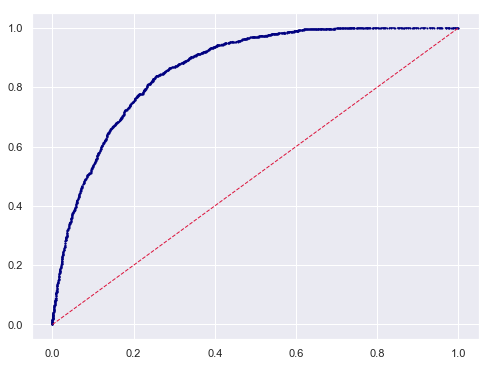

In [328]:
# R O C
from sklearn.svm.libsvm import predict_proba

probs = pd.DataFrame(rf3.predict_proba(test_dt3))
probs = probs[1]
cutoffs = pd.DataFrame({'cutoff':probs.unique()}) 
cutoffs = cutoffs.sort_values('cutoff')
tpr = cutoffs.apply(lambda cut: np.sum(np.logical_and(probs >= cut[0], model_data_test3.final_result == 1)) / np.sum(model_data_test3.final_result == 1), axis=1)
fpr = cutoffs.apply(lambda cut: np.sum(np.logical_and(probs >= cut[0], model_data_test3.final_result == 0)) / np.sum(model_data_test3.final_result == 0), axis=1)
stats = pd.DataFrame({'cutoff':cutoffs.cutoff, 'tpr':tpr, 'fpr':fpr})

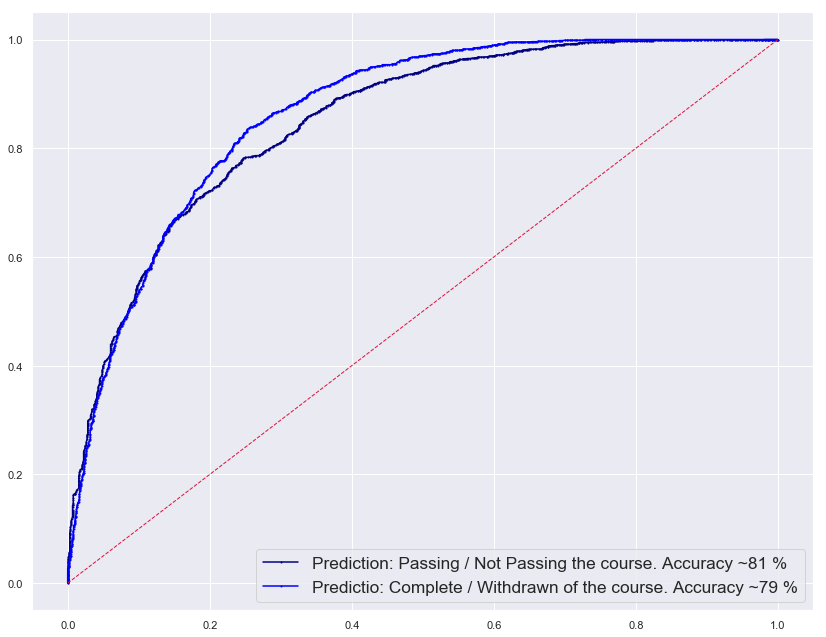

In [350]:
# R O C
from sklearn.svm.libsvm import predict_proba

probs = pd.DataFrame(rf2.predict_proba(test_dt2))
probs = probs[1]
cutoffs = pd.DataFrame({'cutoff':probs.unique()}) 
cutoffs = cutoffs.sort_values('cutoff')

tpr = cutoffs.apply(lambda cut: np.sum(np.logical_and(probs >= cut[0], model_data_test2.final_result == 1)) / np.sum(model_data_test2.final_result == 1), axis=1)
fpr = cutoffs.apply(lambda cut: np.sum(np.logical_and(probs >= cut[0], model_data_test2.final_result == 0)) / np.sum(model_data_test2.final_result == 0), axis=1)
stats2 = pd.DataFrame({'cutoff':cutoffs.cutoff, 'tpr':tpr, 'fpr':fpr})

#rf_df = pd.DataFrame({'prob':probs,'class':rf.predict(test_dt)})
#pd.set_option('display.max_rows', 4000)
#rf_df.sort_values('prob')

pd.set_option('display.max_rows', 10)
rf_val = pd.DataFrame({'actual':model_data_test2.final_result,'predicted':rf2.predict(test_dt2)})
rf_val[rf_val.actual == rf_val.predicted].shape[0] / rf_val.shape[0]

#default_cutoff = 0.501250

default_tpr = np.sum(np.logical_and(probs >= default_cutoff, model_data_test2.final_result == 1)) / np.sum(model_data_test2.final_result == 1)
default_fpr = np.sum(np.logical_and(probs >= default_cutoff, model_data_test2.final_result == 0)) / np.sum(model_data_test2.final_result == 0)
#roc_curve(stats)
figure = plt.figure(figsize=(14,11))
plt.plot(stats2.fpr, stats2.tpr, '-', marker='o', markersize=1, color = "navy", label="Prediction: Passing / Not Passing the course. Accuracy ~81 %")
plt.plot(stats.fpr, stats.tpr, '-', marker='o', markersize=1, color = "blue", label = "Predictio: Complete / Withdrawn of the course. Accuracy ~79 %")
#plt.plot(default_fpr, default_tpr, color='crimson', marker='o', markersize=8)
#plt.annotate('', xy = (default_fpr, default_tpr), xytext=(0.5, 0.75), color="blacredk", size=15)
plt.plot([0,1],[0,1],'--',linewidth=1, markersize=2, color = "crimson")
plt.legend(loc=4, fontsize='x-large')
plt.show()
